In [62]:
from pandas.io.gbq import read_gbq
import pandas as pd 
import geopandas as gpd
print pd.__version__
import seaborn as sns
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 144
import pylab as pl
%pylab inline

import pykml
from pykml import parser
from shapely.geometry import Point
import geopandas as gp

0.19.2
Populating the interactive namespace from numpy and matplotlib


In [2]:
f = open("LinkNYC.kml")
s = parser.fromstring(f.read())
f.close()

In [101]:
# NOTE: the buffer here determines the distance sphere. .001 maps reasonably approximately to 50 feet
coords = [Point(map(float, str(d.Point.coordinates).split(","))[0:2]).buffer(.001)\
          for d in s.Document.Placemark]

In [102]:
link_locs = gp.GeoDataFrame({'geometry': coords})
link_locs.crs = {'init': 'epsg:4326'}

In [91]:
df = pd.concat([pd.read_csv("bus/{}/stops.txt".format(agency)) for agency in ("nyct", "mtabc")],
               ignore_index=True)
geometry = [Point(xy) for xy in zip(df.stop_lon, df.stop_lat)]
stops = gp.GeoDataFrame(df, geometry=geometry)
stops.crs = {'init': 'epsg:4326'}

In [103]:
stops.dropna(subset=['geometry']).drop_duplicates(subset=['stop_lat', 'stop_lon'], inplace=True)
link_locs.dropna(subset=['geometry'], inplace=True)

In [104]:
joined = gpd.sjoin(stops, link_locs, how="inner", op="within")

In [105]:
len(stops)

16259

In [106]:
len(joined)

2270

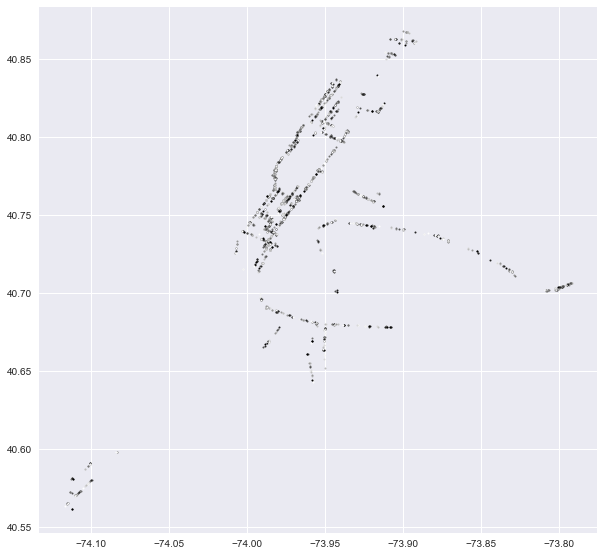

In [107]:
joined.plot(figsize=(10, 10))

In [109]:
with open('viable_stops.geojson', 'w+') as out_f:
    out_f.write(joined.to_json())